In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


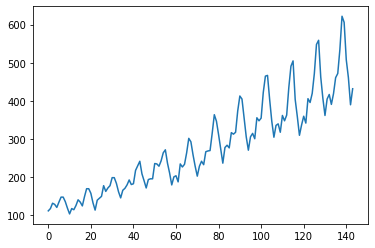

In [3]:
# load the dataset
dataframe = read_csv('/content/international-airline-passengers.csv', usecols=[1])
plt.plot(dataframe)

In [4]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float

In [5]:
# Normalization is optional but recommended for neural network as certain 
# activation functions are sensitive to magnitude of numbers. 
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)


In [6]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [8]:
#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 10 # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

#Compare trainX and dataset. You can see that X= values at t, t+1 and t+2
#whereas Y is the value that follows, t+3 (since our sequence size is 3)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

#Input dimensions are... (N x seq_size)
print('Build deep model...')

Shape of training set: (89, 10)
Shape of test set: (33, 10)
Build deep model...


In [9]:
# create and fit dense model
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu')) #12
model.add(Dense(32, activation='relu'))  #8
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
print(model.summary()) 


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 1s - loss: 0.0886 - acc: 0.0112 - val_loss: 0.3637 - val_acc: 0.0000e+00 - 1s/epoch - 348ms/step
Epoch 2/100
3/3 - 0s - loss: 0.0466 - acc: 0.0112 - val_loss: 0.1759 - val_acc: 0.0000e+00 - 32ms/epoch - 11ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0176 - acc: 0.0112 - val_loss: 0.0652 - val_acc: 0.0000e+00 - 25ms/epoch - 8ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0074 - acc: 0.0112 - val_loss: 0.0273 - val_acc: 0.0303 - 23ms/epoch - 8ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0085 - acc: 0.0112 - val_loss: 0.0286 - val_acc: 0.0303 - 25ms/epoch - 8ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0123 - acc: 0.0112 - val_loss: 0.0302 - val_acc: 0.0303 - 24ms/epoch - 8ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0116 - acc: 0.0112 - val_loss: 0.0258 - val_acc: 0.0303 - 25ms/epoch - 8ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0084 - acc: 0.0112 - val_loss: 0.0239 - val_acc: 0.0303 - 25ms/epoch - 8ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0057 - acc: 0.0112 - val_loss: 0.0280 - val_acc: 0.0303 - 27ms/epoch

In [11]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [12]:
# Estimate model performance
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])


In [13]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 14.95 RMSE
Test Score: 33.04 RMSE


In [14]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

In [20]:
trainPredict

array([[115.562744],
       [116.228676],
       [127.52391 ],
       [129.23796 ],
       [126.22287 ],
       [134.87688 ],
       [143.58536 ],
       [146.12634 ],
       [153.59618 ],
       [169.15387 ],
       [158.10893 ],
       [143.0151  ],
       [123.441   ],
       [128.3468  ],
       [147.38382 ],
       [154.38643 ],
       [147.73074 ],
       [160.36409 ],
       [174.6741  ],
       [190.97688 ],
       [193.56136 ],
       [185.59633 ],
       [182.95816 ],
       [171.01146 ],
       [152.91669 ],
       [154.3002  ],
       [177.02492 ],
       [182.52576 ],
       [184.51988 ],
       [184.01039 ],
       [192.42046 ],
       [204.65767 ],
       [224.0186  ],
       [227.46141 ],
       [217.3491  ],
       [193.21979 ],
       [177.62383 ],
       [185.09816 ],
       [203.13922 ],
       [203.04941 ],
       [201.71863 ],
       [221.44319 ],
       [245.13802 ],
       [260.39673 ],
       [245.04103 ],
       [247.76141 ],
       [254.8422  ],
       [227.4

In [15]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

In [21]:
testPredict

array([[364.49026],
       [383.8199 ],
       [405.85983],
       [426.2862 ],
       [458.4662 ],
       [475.0201 ],
       [471.24866],
       [382.52374],
       [318.68518],
       [326.28833],
       [366.28702],
       [377.44772],
       [381.87753],
       [410.62555],
       [457.70782],
       [489.35077],
       [495.5013 ],
       [517.8913 ],
       [516.05914],
       [414.54922],
       [348.39923],
       [359.34467],
       [425.9622 ],
       [434.2791 ],
       [432.93585],
       [443.34573],
       [501.21533],
       [555.52045],
       [551.1717 ],
       [577.3344 ],
       [555.59955],
       [474.40576],
       [402.95978]], dtype=float32)

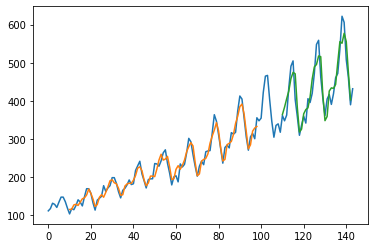

In [16]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()